In [806]:

import pandas as pd
import dotenv
import os
from src.regime.utils import (
    retest_from_latest_base_swing,
    find_all_retest_swing,
    add_peak_regime_data,
)
dotenv.load_dotenv()

True

Control Panel

In [807]:
# Pull price data from db for this ticker
symbol = 'NG=F'
interval = '1d'

In [808]:
# with pandas, select * from enhanced_price_table from NEONDB where symbol = symbol
neon_db_url = os.environ.get("NEON_DB_CONSTR")
# create query select left join where stock_data.stock_id equals select stock_id from stock where symbol = symbol
def get_stock_data(_symbol, _interval, _neon_db_url):
    q = (
         "select {table}.*, stock.symbol, stock.is_relative "
         "from {table} "
         "left join stock on {table}.stock_id = stock.id "
         "where stock.symbol = '{symbol}' "
         "and stock.interval = '{interval}' "
         "{extra}"
    ).format
    
    _stock_data = pd.read_sql(q(table='stock_data', symbol=_symbol, interval=_interval, extra="order by stock_data.bar_number asc"), con=_neon_db_url)
    _regime_data = pd.read_sql(q(table='regime', symbol=_symbol, interval=_interval, extra=""), con=_neon_db_url)
    _peak_data = pd.read_sql(q(table='peak', symbol=_symbol, interval=_interval, extra=""), con=_neon_db_url)
    return _stock_data, _regime_data, _peak_data

def get_data_by_market(_market_index, _interval, _neon_db_url, tables=None):
    if tables is None:
        tables = ['stock_data', 'regime', 'peak']
    q = (
         "select {table}.*, stock.symbol, stock.is_relative "
         "from {table} "
         "left join stock on {table}.stock_id = stock.id "
         "where stock.market_index = '{market}' "
         "and stock.interval = '{interval}' "
         "{extra}"
    ).format
    table_lookup = {
        'stock_data': lambda: pd.read_sql(q(table='stock_data', market=_market_index, interval=_interval, extra="order by stock_data.bar_number asc"), con=_neon_db_url),
        'regime': lambda: pd.read_sql(q(table='regime', market=_market_index, interval=_interval, extra=""), con=_neon_db_url),
        'peak': lambda: pd.read_sql(q(table='peak', market=_market_index, interval=_interval, extra=""), con=_neon_db_url)
    }
    result = [table_lookup[table]() for table in tables]
    return result


In [809]:
stock_data, regime_data, peak_data = get_stock_data(symbol, interval, neon_db_url)
stock_data.index = stock_data.bar_number
stock_data.index.name = 'index'

In [810]:

# plot stock_data close, lo3 as green up arrow, hi3 as red down arrow. rg, sma, and bo plotted on second y axis
def plot(_stock_data, title):
    style_map = {
        'close': '-', # line

        'lo3': 'g^', # green up arrow
        'dlo3': 'k^', # black up arrow (white for dark mode)

        'hi3': 'rv', # red down arrow
        'dhi3': 'kv', # black down arrow (white for dark mode)

        'lo2': 'g.', # green dot
        'dlo2': 'k.', # black dot (white for dark mode)

        'hi2': 'r.', # red dot
        'dhi2': 'm.', # magenta dot

        'fc': 'b--', # blue dashed line
        'sma': 'y--', # yellow dashed line
        'bo': 'k--', # black dashed line (white for dark mode)
        'tt': 'c--' # cyan dashed line
    }
    remove_keys = []
    for key, val in style_map.items():
        if key not in _stock_data.columns:
            remove_keys.append(key)
    for key in remove_keys:
        style_map.pop(key)
    secondary_y = ['fc', 'sma', 'bo', 'tt']
    try:
        _stock_data[
            style_map.keys()].plot(style=list(style_map.values()), secondary_y=secondary_y, figsize=(15, 10), title=title)
    except KeyError:
        pass


In [811]:

peak_data.lvl = peak_data.lvl.astype(int)
absolute_stock_data = add_peak_regime_data(
    stock_data.loc[stock_data.is_relative == False],
    regime_data.loc[regime_data.is_relative == False],
    peak_data.loc[peak_data.is_relative == False]
)


In [812]:

relative_stock_data = add_peak_regime_data(
    stock_data.loc[stock_data.is_relative == True],
    regime_data.loc[regime_data.is_relative == True],
    peak_data.loc[peak_data.is_relative == True]
)


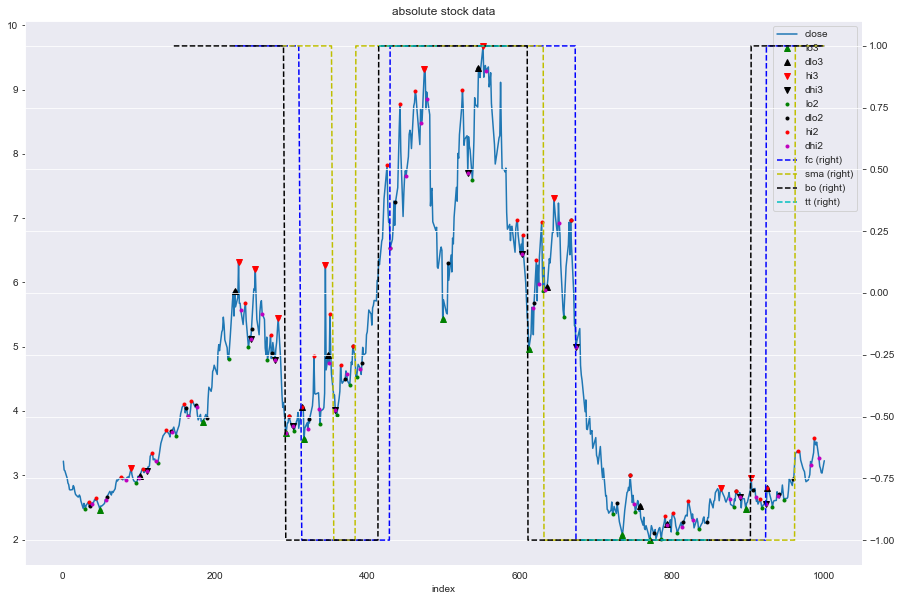

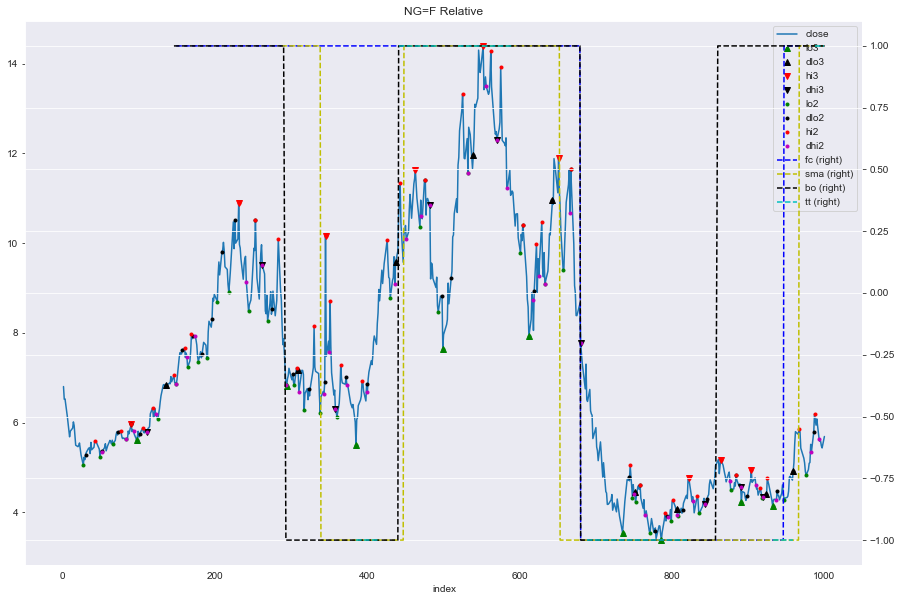

In [813]:
plot(absolute_stock_data, 'absolute stock data')
plot(relative_stock_data, f'{symbol} Relative')

In [814]:
import matplotlib.pyplot as plt
"""
calculate order data
- inputs: peak_row
- order_type (short/long) = peak_row['type']
- stop_loss = peak_row.st_px
- limit_price * order_type <= (peak_row.st_px * order_type) * 1.5 + (order_type *

target_price = en_px + ((en_px - stop_loss) * 1.5)
limit_entry <= (stop_loss * order_type) / (order_type - 0.02)
max_target_price = limit_entry + (limit_entry - stop_loss) * 1.5
if max_target_price < local_max, solve for limit_entry
limit_entry = (max_target_price - (stop_loss * order_type) * 1.5) / (order_type - 0.02)
"""
def entry_data_on_peak(_peak_data, entry_price, return_type):
    entry_data = return_type()
    entry_data['type'] = _peak_data['type']
    entry_data['stop_loss'] = _peak_data['st_px']
    entry_data['limit_entry'] = (entry_data["stop_loss"] * entry_data['type']) / (entry_data['type'] - 0.02)
    entry_data['limit_target_exit'] = entry_data["limit_entry"] + ((entry_data["limit_entry"] - entry_data["stop_loss"]) * .5)
    entry_data['peak_id'] = _peak_data.index
    return entry_data


def latest_entry_data_on_peak(_peak_table, entry_type, swing_lvl, return_type):
    filtered_peaks = _peak_table.loc[(_peak_table.lvl == swing_lvl) & (_peak_table['type'] == entry_type)]
    # sort by start
    selected_peak = filtered_peaks.sort_values(by=['start']).iloc[-1]

    return entry_data_on_peak(filtered_peaks.iloc[-1], return_type)

def create_entry_data():
rel = True
entry_data = relative_stock_data

rel_filtered_regime_data = regime_data.loc[(regime_data.is_relative == True) & (regime_data.type == 'fc')]
abs_filtered_regime_data = regime_data.loc[(regime_data.is_relative == False) & (regime_data.type == 'fc')]

if rel:
    filtered_regime_data = rel_filtered_regime_data
else:
    filtered_regime_data = abs_filtered_regime_data

abs_peak_filtered_entry = peak_data.loc[
    (peak_data.type == abs_filtered_regime_data.iloc[-1].rg) &
    (peak_data.is_relative == False)
    
]

abs_entries_lvl2 = entry_data_on_peak(
    abs_peak_filtered_entry.loc[abs_peak_filtered_entry.lvl == 2],
    0,
    pd.DataFrame)

try: 
    rel_peak_filtered_entry = peak_data.loc[
        (peak_data.type == rel_filtered_regime_data.iloc[-1].rg) &
        (peak_data.is_relative == True)
        
    ]
    rel_entries_lvl2 = entry_data_on_peak(
        rel_peak_filtered_entry.loc[rel_peak_filtered_entry.lvl == 2],
        0,
        pd.DataFrame)
except: 
    pass

def plot_entry_data(_stock_data, _entry_data):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(_stock_data.close)
    ax.axhline(y=_entry_data['stop_loss'], color='r', linestyle='-')
    ax.axhline(y=_entry_data['limit_entry'], color='g', linestyle='-')
    ax.axhline(y=_entry_data['limit_target_exit'], color='b', linestyle='-')

# print latest level 2 entry data
abs_entries_lvl2.iloc[-1]

IndentationError: expected an indented block (4230508337.py, line 33)

In [ ]:
plot_entry_data(absolute_stock_data, abs_entries_lvl2.iloc[-1])

In [ ]:
rel_entries_lvl2.iloc[-1]

In [ ]:
plot_entry_data(relative_stock_data, rel_entries_lvl2.iloc[-1])